### 1. Suppose that there is one factor with $4$ levels. Starting with the usual less than full rank model, find the matrices $D$ and $E$ and verify that $I_4 \ +\  DE$ is rank $4$ for $C_4$ from the `contr.helmert(4)`
 matrix in R. Find the resulting reparameterisation and interpret it in terms of the mean responses for each of the 4 levels.

<img src='res/Q1-1.jpg' width=50%>

In [4]:
contr.helmert(4)

1,-1,-1,-1
2,1,-1,-1
3,0,2,-1
4,0,0,3


In [6]:
# adding intercept
C=matrix(c(1,0,0,0,0,-1,-1,-1,0,1,-1,-1,0,0,2,-1,0,0,0,3),5,4,byrow = TRUE)
Cr=C[1:4,1:4]
E=C[5,1:4]%*%solve(Cr)
print(E)

X=cbind(rep(1,4),diag(4))
D=solve(X[,1:4])%*%X[,5]
print(D)


     [,1] [,2] [,3] [,4]
[1,]    0   -1   -1   -1
     [,1]
[1,]    1
[2,]   -1
[3,]   -1
[4,]   -1


To verify that $I_4 \ +\  DE$ is rank $4$

In [9]:
library("Matrix")
rankMatrix(diag(4)+D%*%E)

[1] 4
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 8.881784e-16

The reparametrization is given for the full rank matrix $Y=XC$:

<img src='res/Q1-2.jpg' width=50%>
<img src='res/Q1-3.jpg' width=50%>

### 2. Fit a binomial regression model to the O-rings data from the Challenger disaster<br>
### a)parameter estimates

In [12]:
orings <- read.csv("orings.csv")
# function to evaluate log-likelihood
l <- function(tha, y, t) {
  eta <- tha[1] + tha[2]*t 
  res=sum(y*log(exp(exp(eta))-1)-6*exp(eta))
 
  return (res)
}

# optim is general purpose optimiser:
# fnscale= -1 spec. max.
betahat <- optim(c(10, -0.1), l,y = orings$orings.damage, t = orings$orings.temp,control = list(fnscale = -1,reltol=1e-16),hessian = FALSE)$par

print(betahat)

[1] 10.863906 -0.205525


### b) 95% CIs for the parameter estimates<br>
fisher information is = -hessian due to assymptotic condition<br>

In [18]:
hessian <- optim(c(10, -0.1), l,y = orings$orings.damage, t = orings$orings.temp,control = list(fnscale = -1,reltol=1e-16),hessian = TRUE)$hessian

# for param 1
fi=-hessian
cov=solve(fi)
std=sqrt(diag(cov))
lb1=betahat[1]-qnorm(1-0.05/2,lower.tail = FALSE)*std[1]
ub1=betahat[1]+qnorm(1-0.05/2,lower.tail = FALSE)*std[1]

print(c(lb1,ub1))

#param 2
lb2=betahat[2]-qnorm(1-0.05/2)*sqrt(diag(solve(-hessian)))[2]
ub2=betahat[2]+qnorm(1-0.05/2)*sqrt(diag(solve(-hessian)))[2]
print(c(lb2,ub2))




[1] 16.463561  5.264252
[1] -0.2981617 -0.1128882


### c) a likelihood ratio test for the significance of the temperature coefficient

In [33]:
l0<- function(tha,y) {
  eta <- tha
  res=sum(y*log(exp(exp(eta))-1)-6*exp(eta))
  
  return (res)
}

nullmodel_betahat=optim(c(-10), l0,y = orings$orings.damage,control = list(fnscale = -1,reltol=1e-16),hessian = FALSE)$par

nullmodel=l0(nullmodel_betahat,orings$orings.damage)
fullmodel=l(betahat,orings$orings.damage,orings$orings.temp)

D=-2*(nullmodel-fullmodel)
print (D)

#print(qchisq(0.05, 23-2))


Warning message in optim(c(-10), l0, y = orings$orings.damage, control = list(fnscale = -1, :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”

[1] 22.86909


This is equivalent to a chisq. If full modell is correct, then the deviance is larger and the temperature is significant. Since Deviance is not close to 0 we can say temperature is significant.

### d) An estimate of the probability of damage when the temperature equals $29$ Fahrenheit together with a $95\%$ CI

In [21]:
q95 <- qnorm(0.975) # normal quantile for 95% ci
si2 <- matrix(c(1, 29), 1, 2) %*%cov%*% matrix(c(1, 29), 2, 1) # estimated variance of linear predictor estimate at 29

# estimate the probability
c_log_log=function(x) 1-exp(-exp(x))
print(c_log_log(betahat[1]+ betahat[2]*29))

#CI
lb=c_log_log(betahat[1]+ betahat[2]*29 - q95*sqrt(si2)) # 95% ci lower
ub=c_log_log(betahat[1]+ betahat[2]*29 + q95*sqrt(si2)) # 95% ci upper
print(c(lb,ub))


[1] 1
[1] 0.9991785 1.0000000


Estimate probability is $1$, that means the probability of damage with temperature of 29 F is almost sure, with a $95\%$ CI we get a probability between 0.99 and 1. If we launch having temperature of 29 F we have certainty that will cause damage in the rocket.  

e)a plot comparing the fitted c-log-log model to the fitted logit model.

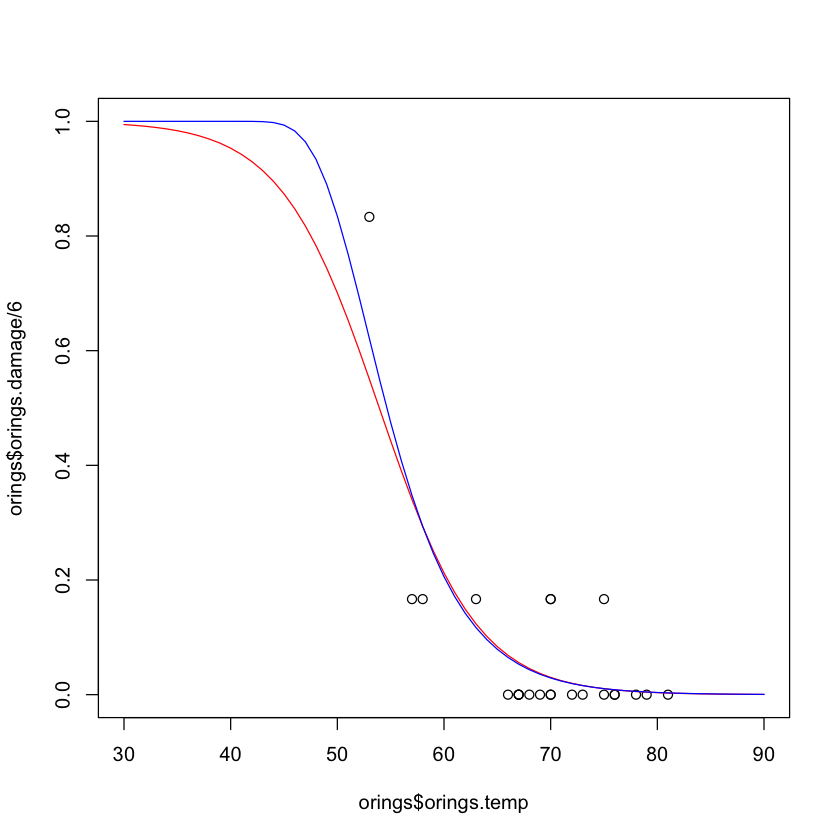

In [24]:
# function to evaluate log-likelihood
ll <- function(tha, y, t) {
  eta <- tha[1] + tha[2]*t 
  return(sum(y*eta - 6*log(1 + exp(eta))))
}
# optim is general purpose optimiser:
# fnscale= -1 spec. max.
betahat_ll <- optim(c(10, -0.1), ll,y = orings$orings.damage, t = orings$orings.temp,control = list(fnscale = -1,reltol=1e-16),hessian = FALSE)$par

#plotting
# fist plot the logit
plot(orings$orings.damage/6 ~ orings$orings.temp, data = orings,xlim = c(30, 90), ylim = c(0, 1))
t <- seq(30, 90, 1)
p_log <- 1/(1 + exp(-betahat_ll[1] - betahat_ll[2]*t)) 
lines(t, p_log, col = "red")

# now plot the c-log-log
p_clog=1-exp(-exp(betahat[1] + betahat[2]*t))
lines(t, p_clog, col = "blue")




### 3. Suppose the $Y$ comes from an exponential family with pdf or pmf $f$ of the form

### a) Show that $EY = b'(θ)$

<img src='res/Q3-1.jpg' width=50%>

### b) Show that $Var Y = b′(θ)a(φ)$

<img src='res/Q3-2-1.jpg' width=50%>
<img src='res/Q3-2-1.jpg' width=50%>

### 4. Steve Sahyun of the University of Winsconsin has a website http://sahyun.net/neutron.php in which he explains neutron activation as a means of producing radioactive metals from standard metals. It includes data on samples of Silver (Ag), Aluminium (Al) and Copper (Cu) which have been subject to neutron activation. For each of the elements, two samples have been tested. The data file Radioactive.csv contains radioactive counts at various times after the initial measure- ment (with the square of time also recorded) as well as the name of the element and whether the count is for the first or second sample.

### a) Use qplot (in package ggplot2 ) to plot the log of counts versus time with different colours for the different elements and different shapes for samples one and two. Your answer should include the plot and your command to get it.

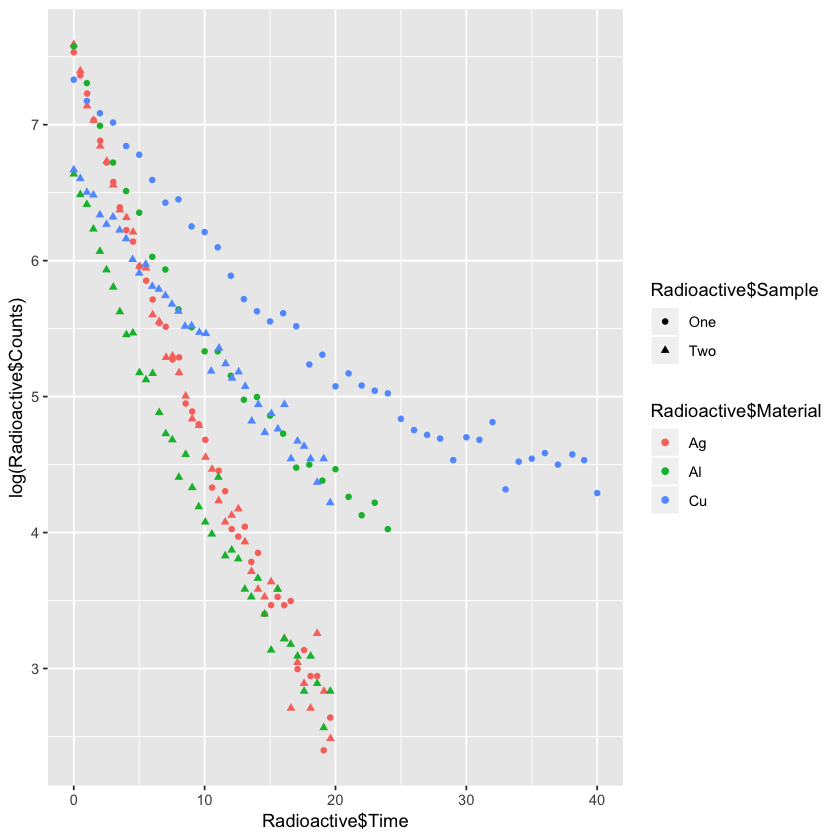

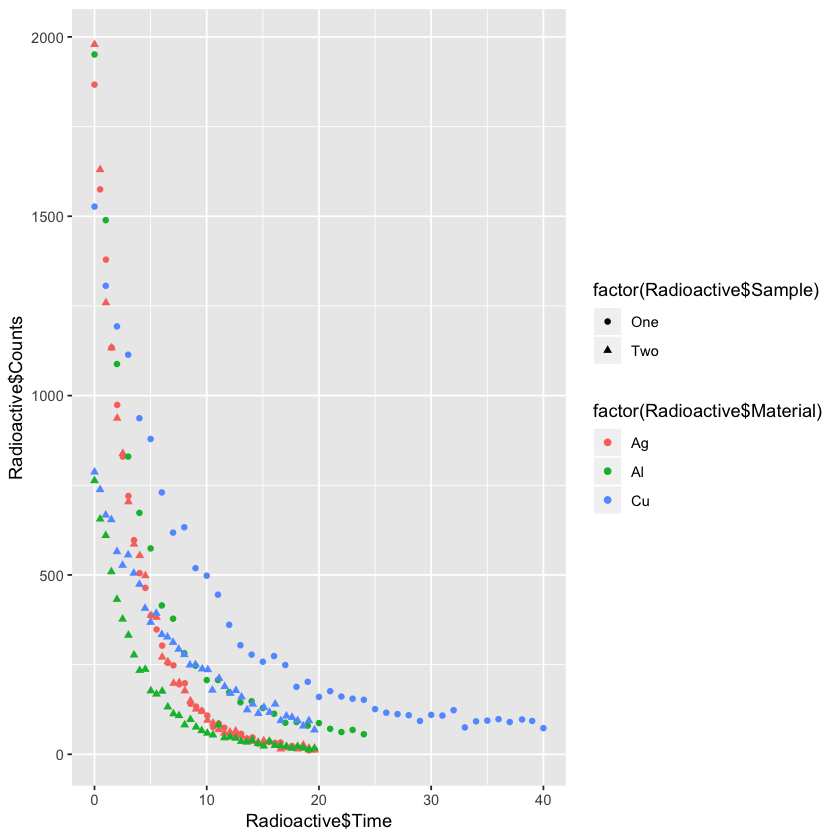

In [69]:
library(ggplot2)
Radioactive= read.csv("Radioactive.csv")
par(mfrow=c(1,2))
qplot(Radioactive$Time, log(Radioactive$Counts), color = Radioactive$Material, shape = Radioactive$Sample, data = Radioactive)
qplot(Radioactive$Time, Radioactive$Counts, color = factor(Radioactive$Material), shape = factor(Radioactive$Sample), data = Radioactive)


### 4.Standard theory on radioactive emissions suggests that counts of them should be Poisson distributed with a varying rate as the radioactivity decays. This suggests a Poisson model for the counts with a log link. Comment on this in the light of the plot in (a). Fit the Poisson model with the log the mean having a linear dependence on time and including factors for both Material and Sample. Do diagnostic plots using plot for the model. Comment and re-fit, if needed, omitting some observations. Use stepwise AIC selection to see if some variables can be omitted. What does the final residual deviance indicate?

#### Plot analysis (from part a))

It is shown in the first plot that log function is transforming data to a linear relationship suitable for linear model, the second plot is not showing a linear pattern. Therefore, the log link is an appropiate link function for the Poisson model.

### Model fit with the log of the mean having a linear dependence on time and including factors for both Material and Sample

In [41]:
model=glm(Radioactive$Counts ~ Radioactive$Time * Radioactive$Material * Radioactive$Sample, data = Radioactive, family = poisson(link = 'log'))
summary(model)


Call:
glm(formula = Radioactive$Counts ~ Radioactive$Time * Radioactive$Material * 
    Radioactive$Sample, family = poisson(link = "log"), data = Radioactive)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.0044  -1.3667   0.0525   1.6273   9.4595  

Coefficients:
                                                               Estimate
(Intercept)                                                    7.455633
Radioactive$Time                                              -0.276965
Radioactive$MaterialAl                                        -0.101620
Radioactive$MaterialCu                                        -0.286063
Radioactive$SampleTwo                                          0.015858
Radioactive$Time:Radioactive$MaterialAl                        0.102834
Radioactive$Time:Radioactive$MaterialCu                        0.188419
Radioactive$Time:Radioactive$SampleTwo                        -0.005514
Radioactive$MaterialAl:Radioactive$SampleTwo                  

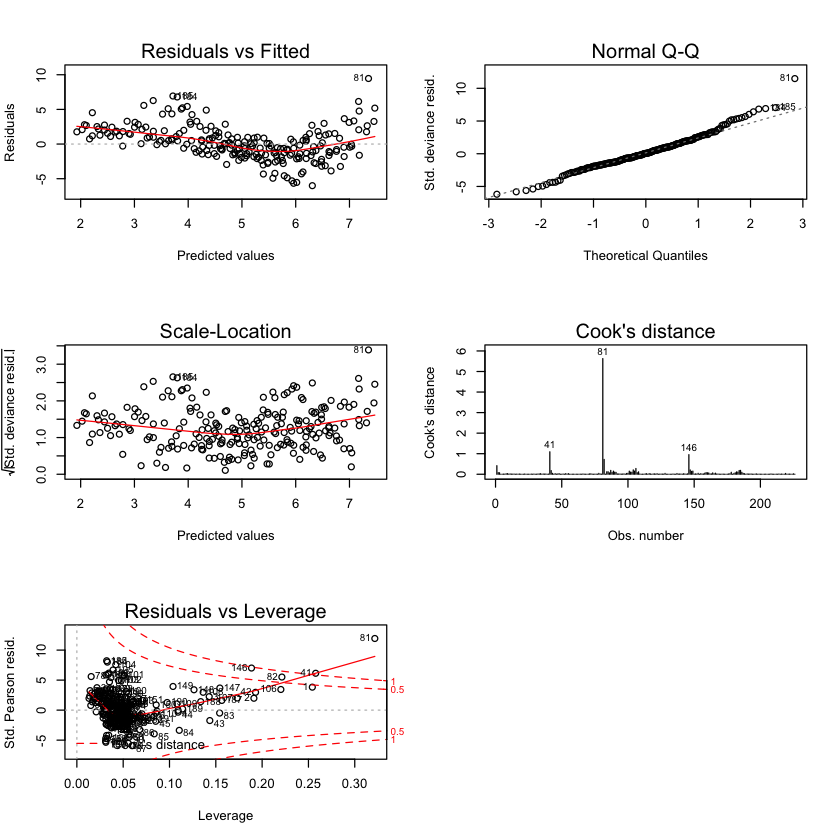

In [65]:
par(mfrow=c(3,2))
plot(model,which = 1)
plot(model,which = 2)
plot(model,which = 3)
plot(model,which = 4)
plot(model,which = 5, id.n = 226)

There is no a particular pattern for the residuals, however, it is shown departure for normality in qqplot for std deviance residuals.  In the last plot, there are particular datapoints with high leverage and risky cook's distance that can cause problems in the model. If we remove this datapoints from the model we analyze the impact and refit the model.


Call:
glm(formula = Radioactive$Counts ~ Radioactive$Time * factor(Radioactive$Material) * 
    factor(Radioactive$Sample), family = poisson(link = "log"), 
    data = new_dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.0044  -1.3667   0.0525   1.6273   9.4595  

Coefficients:
                                                                               Estimate
(Intercept)                                                                    7.455633
Radioactive$Time                                                              -0.276965
factor(Radioactive$Material)Al                                                -0.101620
factor(Radioactive$Material)Cu                                                -0.286063
factor(Radioactive$Sample)Two                                                  0.015858
Radioactive$Time:factor(Radioactive$Material)Al                                0.102834
Radioactive$Time:factor(Radioactive$Material)Cu                          

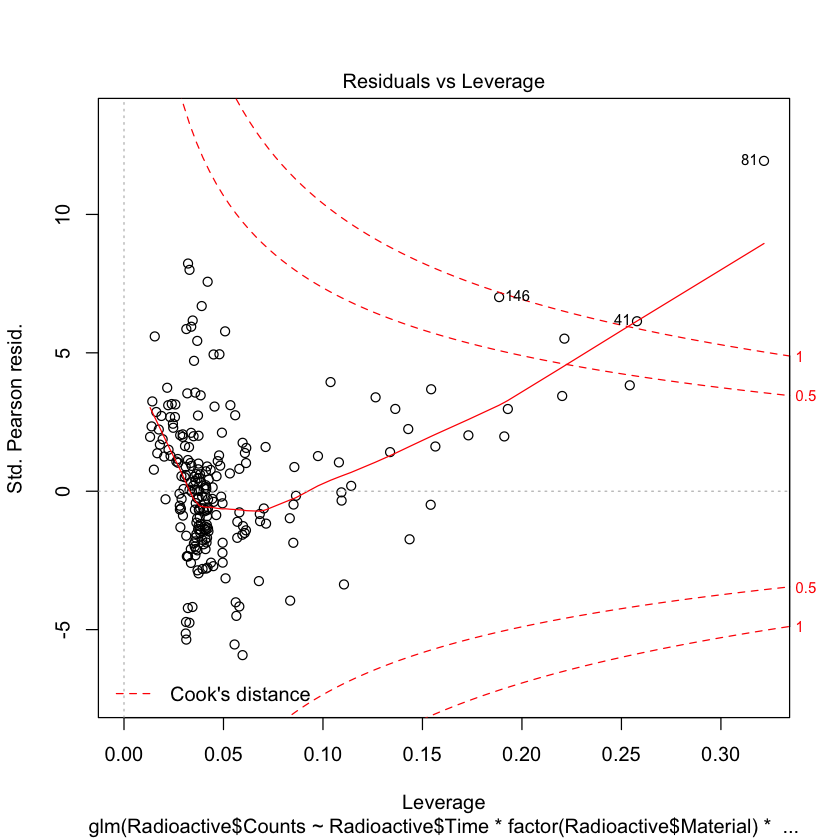

In [70]:
new_dataset <- Radioactive[-c(81, 82, 83,84),]
new_model <-glm(Radioactive$Counts ~ Radioactive$Time * factor(Radioactive$Material) * factor(Radioactive$Sample), data = new_dataset, family = poisson(link = 'log'))
summary(new_model)
plot(new_model,which=5)



In [51]:
step(new_model, scope = ~.)

Start:  AIC=2954.05
Radioactive$Counts ~ Radioactive$Time * factor(Radioactive$Material) * 
    factor(Radioactive$Sample)

                                                                           Df
<none>                                                                       
- Radioactive$Time:factor(Radioactive$Material):factor(Radioactive$Sample)  2
                                                                           Deviance
<none>                                                                       1376.1
- Radioactive$Time:factor(Radioactive$Material):factor(Radioactive$Sample)   1453.2
                                                                              AIC
<none>                                                                     2954.1
- Radioactive$Time:factor(Radioactive$Material):factor(Radioactive$Sample) 3027.2



Call:  glm(formula = Radioactive$Counts ~ Radioactive$Time * factor(Radioactive$Material) * 
    factor(Radioactive$Sample), family = poisson(link = "log"), 
    data = new_dataset)

Coefficients:
                                                                  (Intercept)  
                                                                     7.455633  
                                                             Radioactive$Time  
                                                                    -0.276965  
                                               factor(Radioactive$Material)Al  
                                                                    -0.101620  
                                               factor(Radioactive$Material)Cu  
                                                                    -0.286063  
                                                factor(Radioactive$Sample)Two  
                                                                     0.015858  
  

We should continue exploring the data to find other potential problems. 

c)Try re-fitting the model including TimeSquare as an extra variable to Time but still including Material and Sample. Carry out the additional steps in part (b). Comment on the contrast and comparison with (b).

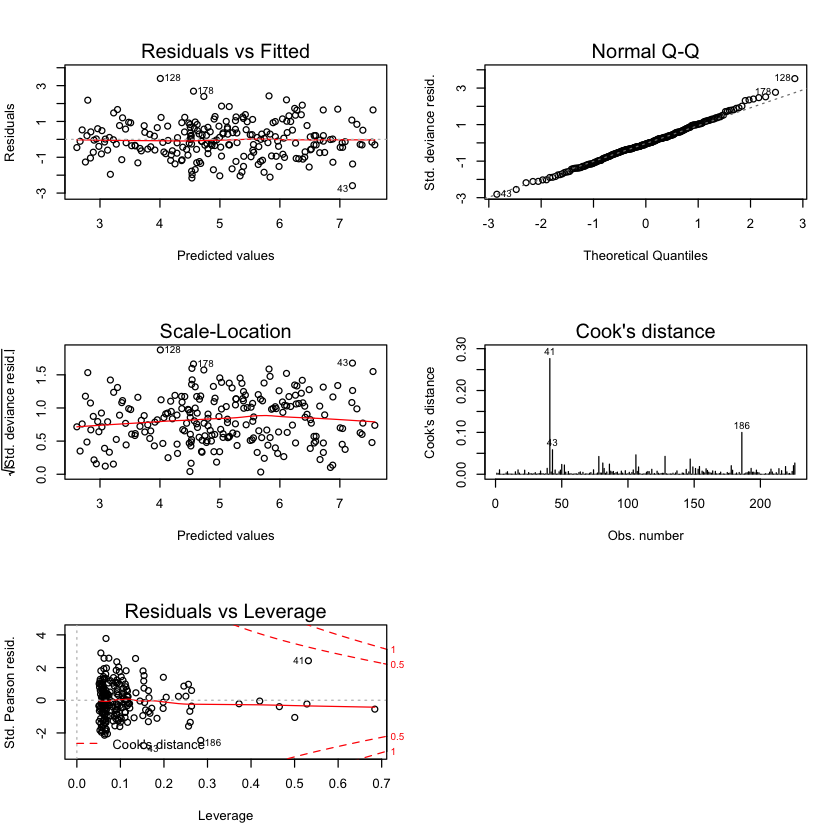

In [71]:
model3 <- glm(Radioactive$Counts ~ Radioactive$Time * Radioactive$TimeSquare * factor(Radioactive$Material) * factor(Radioactive$Sample), data = Radioactive, family = poisson(link = 'log'))
par(mfrow=c(3,2))
plot(model3,which = 1)
plot(model3,which = 2)
plot(model3,which = 3)
plot(model3,which = 4)
plot(model3,which = 5)


Compared with b) It shows less depart from normality in the qqplot and also there are no particular data points with high leverage that can cause problem in the model. Residuals are also showing a more stable pattern.

In [64]:
summary(model3)


Call:
glm(formula = Radioactive$Counts ~ Radioactive$Time * TimeSquare * 
    factor(Radioactive$Material) * factor(Radioactive$Sample), 
    family = poisson(link = "log"), data = Radioactive)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5868  -0.6429  -0.0519   0.5929   3.3992  

Coefficients:
                                                                                           Estimate
(Intercept)                                                                               7.536e+00
Radioactive$Time                                                                         -3.343e-01
TimeSquare                                                                                5.081e-03
factor(Radioactive$Material)Al                                                            4.730e-02
factor(Radioactive$Material)Cu                                                           -1.973e-01
factor(Radioactive$Sample)Two                                               

We can try to use step to see if we can simplify the model 

In [87]:
model4=step(model3, scope = ~.)

Start:  AIC=1827.97
Radioactive$Counts ~ Radioactive$Time * Radioactive$TimeSquare * 
    factor(Radioactive$Material) * factor(Radioactive$Sample)

                                                                                                  Df
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Material):factor(Radioactive$Sample)  2
<none>                                                                                              
                                                                                                  Deviance
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Material):factor(Radioactive$Sample)   227.37
<none>                                                                                              226.04
                                                                                                     AIC
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Material):factor(Radioactive$Sample) 1825.3
<none>           

d)An alternative approach would be to run the same analyses just using the data for one material at a time. Do this. Comment on the comparison with (b) and (c).

In [83]:
dataset_Ag <- Radioactive[Radioactive$Material == 'Ag',]
dataset_Al <- Radioactive[Radioactive$Material == 'Al',]
dataset_Cu <- Radioactive[Radioactive$Material == 'Cu',]
model_Ag <- glm(dataset_Ag$Counts ~ dataset_Ag$Time * dataset_Ag$TimeSquare * factor(dataset_Ag$Sample), data = dataset_Ag, family = poisson(link = 'log'))
model_Al <- glm(dataset_Al$Counts ~ dataset_Al$Time * dataset_Al$TimeSquare * factor(dataset_Al$Sample), data = dataset_Al, family = poisson(link = 'log'))
model_Cu <- glm(dataset_Cu$Counts ~ dataset_Cu$Time * dataset_Cu$TimeSquare * factor(dataset_Cu$Sample), data = dataset_Cu, family = poisson(link = 'log'))


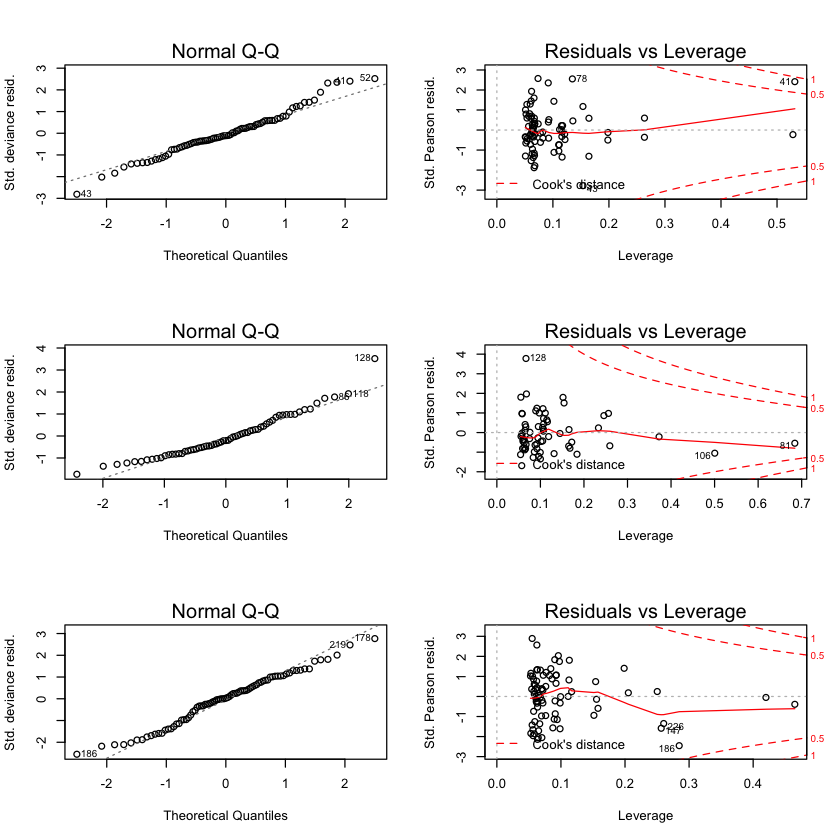

In [84]:
par(mfrow=c(3,2))
plot(model_Ag, which = 2)
plot(model_Ag, which = 5)

plot(model_Al, which = 2)
plot(model_Al, which = 5)

plot(model_Cu, which = 2)
plot(model_Cu, which = 5)

It is easy to identify outliers and datapoints with high leverage that can cause problems, specially for Ag there is and importar departure from normality and high leverage datapoints that can potentially present problems in the model.

In [62]:
step(model_Ag, scope = ~.)
step(model_Al, scope = ~.)
step(model_Cu, scope = ~.)

Start:  AIC=12702.7
Radioactive$Counts ~ Radioactive$Time * Radioactive$TimeSquare * 
    factor(Radioactive$Sample)

                                                                     Df
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)  1
<none>                                                                 
                                                                     Deviance
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)    11134
<none>                                                                  11133
                                                                       AIC
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample) 12702
<none>                                                               12703

Step:  AIC=12701.95
Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Samp


Call:  glm(formula = Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Sample) + Radioactive$TimeSquare:factor(Radioactive$Sample), 
    family = poisson(link = "log"), data = dataset_Ag)

Coefficients:
                                         (Intercept)  
                                           7.519e+00  
                                    Radioactive$Time  
                                          -2.955e-01  
                              Radioactive$TimeSquare  
                                           9.362e-03  
                       factor(Radioactive$Sample)Two  
                                          -4.721e-01  
             Radioactive$Time:Radioactive$TimeSquare  
                                          -9.511e-05  
      Radioactive$Time:factor(Radioactive$Sample)Two  
                                           1.102e-02  
Radi

Start:  AIC=12702.7
Radioactive$Counts ~ Radioactive$Time * Radioactive$TimeSquare * 
    factor(Radioactive$Sample)

                                                                     Df
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)  1
<none>                                                                 
                                                                     Deviance
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)    11134
<none>                                                                  11133
                                                                       AIC
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample) 12702
<none>                                                               12703

Step:  AIC=12701.95
Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Samp


Call:  glm(formula = Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Sample) + Radioactive$TimeSquare:factor(Radioactive$Sample), 
    family = poisson(link = "log"), data = dataset_Al)

Coefficients:
                                         (Intercept)  
                                           7.519e+00  
                                    Radioactive$Time  
                                          -2.955e-01  
                              Radioactive$TimeSquare  
                                           9.362e-03  
                       factor(Radioactive$Sample)Two  
                                          -4.721e-01  
             Radioactive$Time:Radioactive$TimeSquare  
                                          -9.511e-05  
      Radioactive$Time:factor(Radioactive$Sample)Two  
                                           1.102e-02  
Radi

Start:  AIC=12702.7
Radioactive$Counts ~ Radioactive$Time * Radioactive$TimeSquare * 
    factor(Radioactive$Sample)

                                                                     Df
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)  1
<none>                                                                 
                                                                     Deviance
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample)    11134
<none>                                                                  11133
                                                                       AIC
- Radioactive$Time:Radioactive$TimeSquare:factor(Radioactive$Sample) 12702
<none>                                                               12703

Step:  AIC=12701.95
Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Samp


Call:  glm(formula = Radioactive$Counts ~ Radioactive$Time + Radioactive$TimeSquare + 
    factor(Radioactive$Sample) + Radioactive$Time:Radioactive$TimeSquare + 
    Radioactive$Time:factor(Radioactive$Sample) + Radioactive$TimeSquare:factor(Radioactive$Sample), 
    family = poisson(link = "log"), data = dataset_Cu)

Coefficients:
                                         (Intercept)  
                                           7.519e+00  
                                    Radioactive$Time  
                                          -2.955e-01  
                              Radioactive$TimeSquare  
                                           9.362e-03  
                       factor(Radioactive$Sample)Two  
                                          -4.721e-01  
             Radioactive$Time:Radioactive$TimeSquare  
                                          -9.511e-05  
      Radioactive$Time:factor(Radioactive$Sample)Two  
                                           1.102e-02  
Radi